In [8]:
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from training_utils import Config, load_data

In [10]:
class SqueezeExcite(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.SiLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale


class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_residual = (in_channels == out_channels and stride == 1)
        self.expand_ratio = expand_ratio

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.SiLU())
        else:
            hidden_dim = in_channels  # IMPORTANT: actual conv input

        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.SiLU())

        self.se = SqueezeExcite(hidden_dim)  # must match conv output dim

        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.expand_ratio != 1:
            out = self.block[0:3](x)
            out = self.block[3](out)  # depthwise
            out = self.block[4](out)
            out = self.block[5](out)
            out = self.se(out)
            out = self.block[6:](out)
        else:
            out = self.block[0](x)
            out = self.block[1](out)
            out = self.block[2](out)
            out = self.se(out)
            out = self.block[3:](out)
        return x + out if self.use_residual else out


class CustomEfficientNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )

        self.blocks = nn.Sequential(
            MBConvBlock(32, 16, expand_ratio=1, stride=1),
            MBConvBlock(16, 24, expand_ratio=6, stride=2),
            MBConvBlock(24, 24, expand_ratio=6, stride=1),
            MBConvBlock(24, 40, expand_ratio=6, stride=2),
            MBConvBlock(40, 40, expand_ratio=6, stride=1),
            MBConvBlock(40, 80, expand_ratio=6, stride=2),
            MBConvBlock(80, 80, expand_ratio=6, stride=1),
            MBConvBlock(80, 112, expand_ratio=6, stride=1),
            MBConvBlock(112, 112, expand_ratio=6, stride=1),
            MBConvBlock(112, 192, expand_ratio=6, stride=2),
            MBConvBlock(192, 192, expand_ratio=6, stride=1),
            MBConvBlock(192, 320, expand_ratio=6, stride=1)
        )

        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, config.num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        return self.head(x)


class PoseTrainer:
    def __init__(self, config, device):
        self.config = config
        self.device = device
        self.best_metric = 0
        self.train_set, self.val_set, self.test_set = load_data(config)

        self.train_loader = DataLoader(
            self.train_set,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        self.val_loader = DataLoader(
            self.val_set,
            batch_size=config.batch_size,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )
        self.test_loader = DataLoader(
            self.test_set,
            batch_size=config.batch_size,
            num_workers=6,
            pin_memory=True,
            prefetch_factor=4,
            persistent_workers=True
        )

        self.model = CustomEfficientNet(config).to(device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=config.epochs)
        self.criterion = nn.CrossEntropyLoss()
        self.scaler = torch.cuda.amp.GradScaler(enabled=device.type != 'cpu')

    def train(self):
        os.makedirs(self.config.save_dir, exist_ok=True)
        history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

        for epoch in range(self.config.epochs):
            self.model.train()
            total_loss = 0
            all_preds, all_labels = [], []

            for images, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.epochs}"):
                images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                self.optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.detach().cpu().numpy())

            val_metrics = self.evaluate(self.val_loader)
            self.scheduler.step()

            history['train_loss'].append(total_loss / len(self.train_loader))
            history['val_loss'].append(val_metrics['loss'])
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_f1'].append(val_metrics['f1'])

            print(f"Val F1: {val_metrics['f1']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")

            if val_metrics['f1'] > self.best_metric:
                self.best_metric = val_metrics['f1']
                torch.save(self.model.state_dict(), os.path.join(self.config.save_dir, 'best_model.pth'))

        self.plot_training(history)

    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        return {
            'loss': total_loss / len(loader),
            'accuracy': np.mean(np.array(all_preds) == np.array(all_labels)),
            'f1': f1_score(all_labels, all_preds, average='weighted')
        }

    def plot_training(self, history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(history['val_acc'], label='Val Acc')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 3, 3)
        plt.plot(history['val_f1'], label='Val F1')
        plt.legend()
        plt.title('F1 Score')

        plt.tight_layout()
        plt.savefig(os.path.join(self.config.save_dir, 'training_metrics.png'))
        plt.show()


[1/4] Загрузка данных...
Пример данных:
   img_id  target_feature
0   17363               2
1    8612               5
2    8244               0
3    9264               0
4    5382               6

[2/4] Валидация данных...
Данных после очистки: 12367

[3/4] Проверка изображений...
Найдено изображений: 12367
Данных после фильтрации: 12367

[4/4] Разделение данных...


/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=device.type != 'cpu')
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
CustomEfficientNet                                 [32, 20]                  --
├─Sequential: 1-1                                  [32, 32, 112, 112]        --
│    └─Conv2d: 2-1                                 [32, 32, 112, 112]        864
│    └─BatchNorm2d: 2-2                            [32, 32, 112, 112]        64
│    └─SiLU: 2-3                                   [32, 32, 112, 112]        --
├─Sequential: 1-2                                  [32, 320, 7, 7]           --
│    └─MBConvBlock: 2-4                            [32, 16, 112, 112]        --
│    │    └─Sequential: 3-3                        --                        (recursive)
│    │    └─SqueezeExcite: 3-2                     [32, 32, 112, 112]        552
│    │    └─Sequential: 3-3                        --                        (recursive)
│    └─MBConvBlock: 2-5                            [32, 24, 56, 56]          --
│    │    └─Seq

Epoch 1/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.52it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.1689 | Val Acc: 0.2566


Epoch 2/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.1925 | Val Acc: 0.2604


Epoch 3/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.92it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2510 | Val Acc: 0.3013


Epoch 4/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.06it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2809 | Val Acc: 0.3229


Epoch 5/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.96it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2612 | Val Acc: 0.3084


Epoch 6/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.99it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2745 | Val Acc: 0.3240


Epoch 7/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.2937 | Val Acc: 0.3526


Epoch 8/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3260 | Val Acc: 0.3650


Epoch 9/50:   0%|                                                                                  | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3333 | Val Acc: 0.3693


Epoch 10/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3300 | Val Acc: 0.3698


Epoch 11/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3323 | Val Acc: 0.3736


Epoch 12/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3308 | Val Acc: 0.3790


Epoch 13/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3699 | Val Acc: 0.3935


Epoch 14/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3559 | Val Acc: 0.3919


Epoch 15/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3869 | Val Acc: 0.4119


Epoch 16/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.75it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3655 | Val Acc: 0.3984


Epoch 17/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.78it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3899 | Val Acc: 0.4216


Epoch 18/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.79it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3901 | Val Acc: 0.4173


Epoch 19/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.80it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.3776 | Val Acc: 0.4043


Epoch 20/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4022 | Val Acc: 0.4313


Epoch 21/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.81it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4128 | Val Acc: 0.4334


Epoch 22/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.85it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4057 | Val Acc: 0.4356


Epoch 23/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4197 | Val Acc: 0.4437


Epoch 24/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4269 | Val Acc: 0.4539


Epoch 25/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.36it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4140 | Val Acc: 0.4464


Epoch 26/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.29it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4532 | Val Acc: 0.4776


Epoch 27/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.16it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4500 | Val Acc: 0.4749


Epoch 28/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.26it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4475 | Val Acc: 0.4755


Epoch 29/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.25it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4557 | Val Acc: 0.4819


Epoch 30/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.26it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4641 | Val Acc: 0.4868


Epoch 31/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.24it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4620 | Val Acc: 0.4863


Epoch 32/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.24it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4595 | Val Acc: 0.4841


Epoch 33/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.23it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4692 | Val Acc: 0.4906


Epoch 34/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.16it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4847 | Val Acc: 0.5035


Epoch 35/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.07it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4840 | Val Acc: 0.5040


Epoch 36/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.08it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4840 | Val Acc: 0.5024


Epoch 37/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.05it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4893 | Val Acc: 0.5073


Epoch 38/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.08it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4883 | Val Acc: 0.5078


Epoch 39/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.25it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4953 | Val Acc: 0.5159


Epoch 40/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4978 | Val Acc: 0.5154


Epoch 41/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4913 | Val Acc: 0.5073


Epoch 42/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4925 | Val Acc: 0.5094


Epoch 43/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4964 | Val Acc: 0.5154


Epoch 44/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5046 | Val Acc: 0.5224


Epoch 45/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.4995 | Val Acc: 0.5164


Epoch 46/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.11it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5046 | Val Acc: 0.5240


Epoch 47/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.19it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5028 | Val Acc: 0.5170


Epoch 48/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.03it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5069 | Val Acc: 0.5240


Epoch 49/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.02it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5109 | Val Acc: 0.5267


Epoch 50/50:   0%|                                                                                 | 0/271 [00:00<?, ?it/s]/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.04it/s]
/var/folders/06/4mfvxfgx51scnyqsczh6cd900000gn/T/ipykernel_26329/3831681715.py:192: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.device.type != 'cpu'):


Val F1: 0.5041 | Val Acc: 0.5213


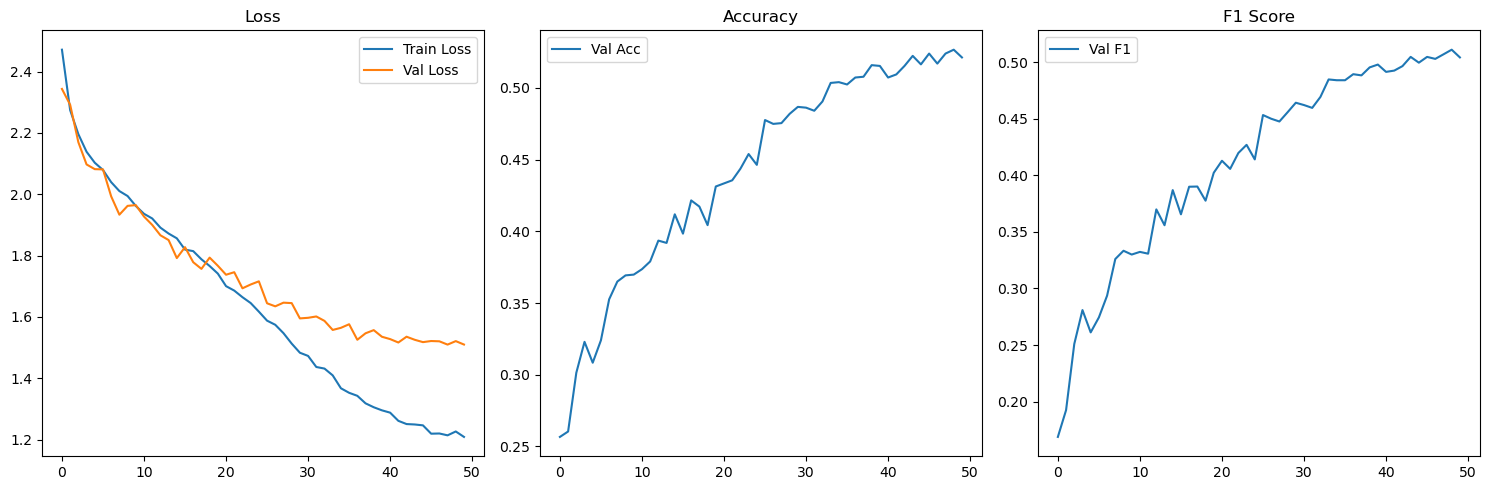

In [12]:
if __name__ == "__main__":
    device = torch.device('mps')
    config = Config()
    trainer = PoseTrainer(config, device)

    # Модельный summary
    from torchinfo import summary
    print(summary(trainer.model, input_size=(config.batch_size, 3, *config.img_size), device=device.type))
    
    trainer.train()